# Course 4 - Logistic Regression

## Import librairies and dataset

In [ ]:
#!pip install pandas seaborn matplotlib scikit-learn gensim eli5 tiktoken spacy

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import tiktoken
import eli5

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier

from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop

/home/gcortal/anaconda3/envs/epita/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/gcortal/anaconda3/envs/epita/lib/python3.9/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025831482/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
dataset = load_dataset("gustavecortal/DreamBank-annotated")
df = dataset["train"].to_pandas()
df = df.sample(frac = 1)
df["report"] = df["report"].astype(str)
df = df.query("emotion == 'CO D' or emotion == 'AN D' or emotion == 'SD D' or emotion == 'AP D' or emotion == 'HA D'")[["report", "emotion"]]
df.head()

,report,emotion
17117,<i>Apricots</i> <br/><br/> I'm in a grocery st...,AP D
10387,I am diagnosed as having a serious incurable d...,CO D
27218,"I remember these dreams in continuity, but onl...",HA D
23930,I took my family and a miniature train and I r...,AN D
12844,I was at school. I was talking to Madelyn abou...,CO D


## Preprocessing and visualization

Convert code to emotion class according to the annotation guideline : https://dreams.ucsc.edu/Coding/emotions.html

In [3]:
def to_emotion_class(emotion):
    
    if emotion == "AP D":
        return "fear"
    elif emotion == "CO D":
        return "confusion"
    elif emotion == "SD D":
        return "sadness"
    elif emotion == "AN D":
        return "anger"
    else:
        return "happiness"

df["emotion"] = df["emotion"].apply(lambda x: to_emotion_class(x))
df["report"] = df["report"].apply(lambda x: x.lower()) # simple preprocessing (lowercase only)
df.head()

,report,emotion
17117,<i>apricots</i> <br/><br/> i'm in a grocery st...,fear
10387,i am diagnosed as having a serious incurable d...,confusion
27218,"i remember these dreams in continuity, but onl...",happiness
23930,i took my family and a miniature train and i r...,anger
12844,i was at school. i was talking to madelyn abou...,confusion


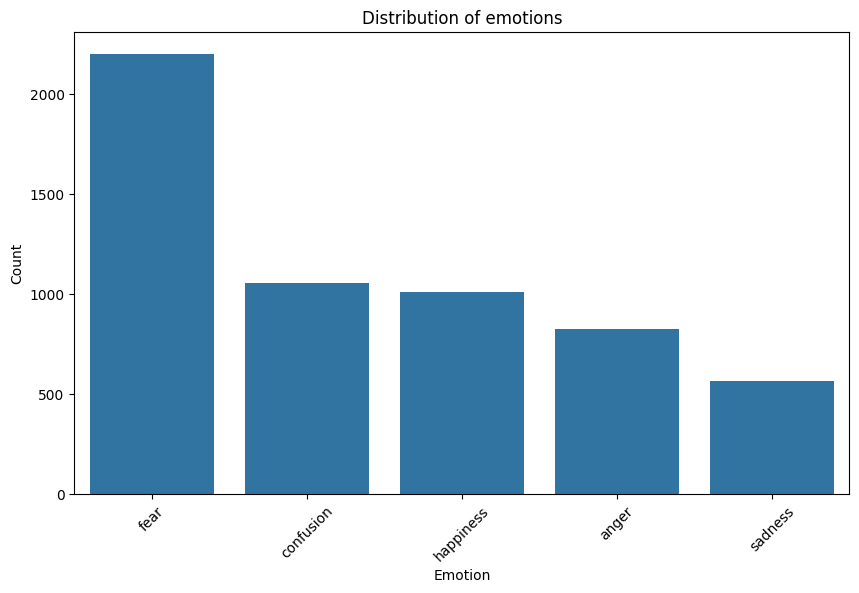

In [4]:
plt.figure(figsize=(10, 6))
sns.countplot(x='emotion', data=df)

plt.title('Distribution of emotions') 
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

## Training and test sets

In [5]:
X = df['report']
y = df['emotion']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

## Tokenization functions

In [7]:
def lemma_tokenize(doc):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(t) for t in word_tokenize(doc)]

def char_tokenize(doc):
    return [char for char in doc]

def byte_tokenize(doc):
    tokens = doc.encode("utf-8")
    tokens = list(map(int, tokens))
    return [str(token) for token in tokens]

def gpt_tokenize(doc):
    enc = tiktoken.encoding_for_model("gpt-4")
    tokens = enc.encode(doc)
    return [str(token) for token in tokens]

## Training: Logistic Regression

In [26]:
model = make_pipeline(CountVectorizer(), LogisticRegression(random_state=42, penalty = 'none'))
model = make_pipeline(CountVectorizer(), LogisticRegression(random_state=42, class_weight='balanced', penalty = 'none'))
model = make_pipeline(CountVectorizer(), LogisticRegression(random_state=42, class_weight='balanced', penalty = 'l2'))
model = make_pipeline(CountVectorizer(), LogisticRegression(random_state=42, class_weight='balanced', penalty = 'l2', max_iter = 1000))
model = make_pipeline(CountVectorizer(), LogisticRegression(random_state=42, class_weight='balanced', penalty = 'l1', max_iter = 1000, C = 1, solver = 'liblinear')) # mauvaise performance avec saga car le modèle ne converge pas

In [27]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Features dimension: {len(X_train), len(model[0].vocabulary_)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Features dimension: (4520, 21235)
Classification Report:
               precision    recall  f1-score   support

       anger       0.83      0.76      0.80       176
   confusion       0.77      0.78      0.77       209
        fear       0.84      0.87      0.85       448
   happiness       0.73      0.80      0.77       184
     sadness       0.63      0.55      0.59       113

    accuracy                           0.79      1130
   macro avg       0.76      0.75      0.75      1130
weighted avg       0.79      0.79      0.79      1130



In [30]:
model[1].coef_.shape

(5, 21235)

In [31]:
model[1].coef_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
nb_parameters = model[1].coef_.shape[0]*model[1].coef_.shape[1]
print("Model parameters:",nb_parameters)

Model parameters: 106175


In [33]:
import numpy as np

def count_zeros(*arrays):
    combined_array = np.concatenate(arrays)
    zero_count = np.sum(combined_array == 0)
    return zero_count

nb_zero = count_zeros(model[1].coef_)
print(f"Total number of zeros: {nb_zero}")

Total number of zeros: 102350


In [34]:
nb_parameters - nb_zero

3825

## Plot confusion matrix

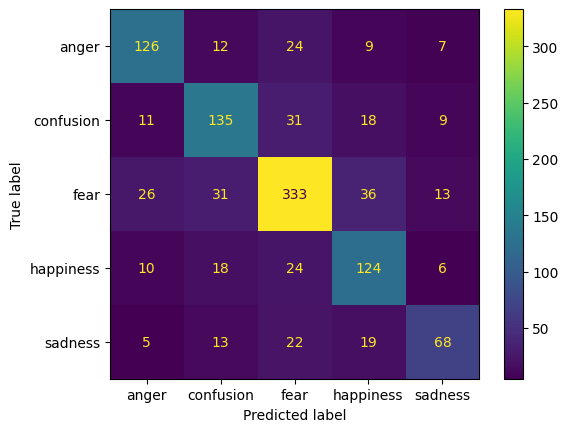

In [49]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
disp.plot()
plt.show()

## Show feature importances

In [35]:
html = eli5.show_weights(estimator=model, top=(50, 5))
html

/home/gcortal/anaconda3/envs/epita/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Ensembling

In [24]:
log_clf = LogisticRegression(random_state=42, max_iter=1000)
nb_clf = MultinomialNB()

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('nb', nb_clf)], voting='soft')

model = make_pipeline(CountVectorizer(), voting_clf)

## Cross validation

In [25]:
scoring = 'f1_macro'
scores = cross_val_score(model, X, y, cv=5, scoring=scoring, n_jobs = -1)
print(f"Mean {scoring}: {scores.mean()}")
print(f"Standard deviation {scoring}: {scores.std()}")

Mean f1_macro: 0.508971398369636
Standard deviation f1_macro: 0.012406033049705908


## Optimize hyperparameters using Grid Search

In [39]:
model = make_pipeline(CountVectorizer(), LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear'))

param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score:", test_score)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'logisticregression__C': 1, 'logisticregression__penalty': 'l1'}
Best cross-validation score: 0.752532203197065
Test set score: 0.7902654867256638
